In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap




In [3]:
def generate_synthetic_data(n_samples=1000, mean1=(2, 2), mean2=(4, 4), cov=[[1, 0.5], [0.5, 1]],
                            random_seed=42):

    np.random.seed(random_seed)
    n_samples_per_class = n_samples // 2
    
    X0 = np.random.multivariate_normal(mean1, cov, n_samples_per_class)
    y0 = np.zeros(n_samples_per_class)
    
    X1 = np.random.multivariate_normal(mean2, cov, n_samples_per_class)
    y1 = np.ones(n_samples_per_class)

    X = np.vstack((X0, X1))
    y = np.hstack((y0, y1))
    
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y


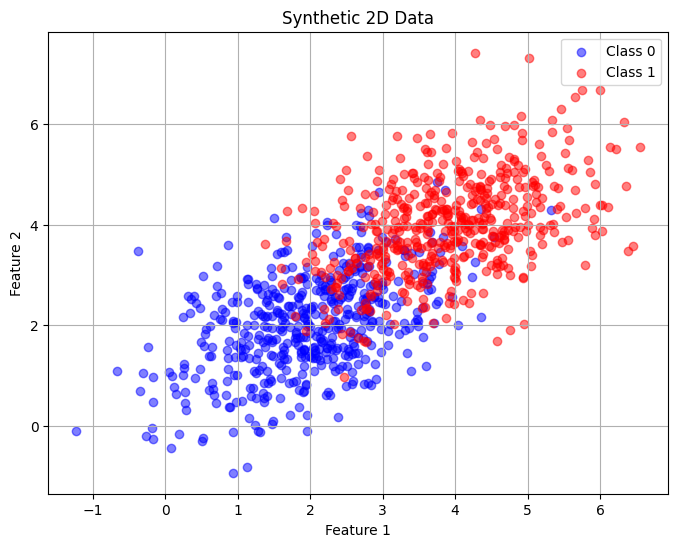

In [4]:
X, y = generate_synthetic_data(n_samples=1000, mean1=(2, 2), mean2=(4, 4), cov=[[1, 0.5], [0.5, 1]])

def plot_data(X, y, title='Synthetic 2D Data'):
    plt.figure(figsize=(8,6))
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color='blue', label='Class 0', alpha=0.5)
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='red', label='Class 1', alpha=0.5)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data(X, y)

In [5]:
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, num_iterations=1000, fit_intercept=True, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.weights = None
        self.bias = None
    
    def add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.hstack((intercept, X))
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def initialize_parameters(self, n_features):
        self.weights = np.zeros(n_features)
        self.bias = 0
    
    def compute_loss(self, h, y):
        m = y.shape[0]
        loss = - (1/m) * np.sum(y*np.log(h + 1e-15) + (1 - y)*np.log(1 - h + 1e-15))
        return loss
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.add_intercept(X)
        
        n_samples, n_features = X.shape
        self.initialize_parameters(n_features)
        
        for i in range(self.num_iterations):
            z = np.dot(X, self.weights) + self.bias if self.fit_intercept else np.dot(X, self.weights)
            h = self.sigmoid(z)

            gradient = np.dot(X.T, (h - y)) / n_samples

            self.weights -= self.learning_rate * gradient

            if self.fit_intercept:
                self.bias -= self.learning_rate * np.sum(h - y) / n_samples
            
            if self.verbose and i % 100 == 0:
                loss = self.compute_loss(h, y)
                print(f'Iteration {i}: Loss = {loss:.4f}')
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.add_intercept(X)
        z = np.dot(X, self.weights) + self.bias if self.fit_intercept else np.dot(X, self.weights)
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_prob(X) >= threshold).astype(int)


In [6]:
def train_test_split_manual(X, y, test_size=0.3, random_seed=42):
    np.random.seed(random_seed)
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    test_size = int(n_samples * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2, random_seed=42)

print(f'Training samples: {X_train.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')


Training samples: 800
Testing samples: 200


In [7]:

model = LogisticRegressionScratch(learning_rate=0.1, num_iterations=1000, fit_intercept=True, verbose=True)

model.fit(X_train, y_train)


Iteration 0: Loss = 0.6931
Iteration 100: Loss = 0.4522
Iteration 200: Loss = 0.3820
Iteration 300: Loss = 0.3484
Iteration 400: Loss = 0.3293
Iteration 500: Loss = 0.3171
Iteration 600: Loss = 0.3088
Iteration 700: Loss = 0.3029
Iteration 800: Loss = 0.2985
Iteration 900: Loss = 0.2952


In [8]:
def accuracy_score_manual(y_true, y_pred):
    return np.mean(y_true == y_pred)
    

def confusion_matrix_manual(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    return np.array([[tn, fp],
                     [fn, tp]])

def classification_report_manual(y_true, y_pred):
    cm = confusion_matrix_manual(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    accuracy = accuracy_score_manual(y_true, y_pred)
    
    report = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1
    }
    return report


In [9]:
y_pred_prob = model.predict_prob(X_test)

y_pred = model.predict(X_test)

accuracy = accuracy_score_manual(y_test, y_pred)
cm = confusion_matrix_manual(y_test, y_pred)
report = classification_report_manual(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
# все верные предсказания / все предсказания
# сама по себе не очень полезна, особенно если датасет "странный", но позволяет быстро определить
# насколько все плохо  
print('Confusion Matrix:')
print(cm)
print("True Negative || False Positive")
print("False Negative || True Positive")
# Самая информативная метрика, от того и сложно читаемая
#  |                  | Predicted Positive | Predicted Negative |
#  |------------------|--------------------|--------------------|
#  | Actual Positive  | True Positive (TP) | False Negative (FN)|
#  | Actual Negative  | False Positive (FP)| True Negative (TN) |
# Показывает насколько хорошо модель справилась с классификацией. Вообще матрица может быть любого
# "квадратного" размера, но в таком случае ее исследовать становится тяжелее и тяжелее, поэтому 
# рассмотрим 2х2. ТР это когда значение = 1 и нейронка сказала что значение = 1. ТN соответственно 
# наоборот. FN и FP это когда нейронка ошибается в ту или иную сторону. По этой матрице можно 
# понять что вообще нейронка научилась делать. К примеру если вы изначально хотели научить ее 
# различать 10 классов, но так вышло что она может с хорошей точностью определять лишь 1, то 
# это будет заметно только в этой матрице, но не в accuracy 


print(f"Precision: {report['precision']:.4f}")
# это отношения количества реальных 1 к сумме всех предсказанных едениц TP/(TP+FP). Собственно по
# этой метрике можно как раз увидеть что 1 из 10 классов предсказывается очень хорошо, тогда как 
# общая точность плоха 
print(f"Recall: {report['recall']:.4f}")
# а тут отношение количества реальных едениц к сумме из предсказанных едениц и "недопредсказанных"
# едениц. Это нужно когда нам очень важно чтобы минимальное количество едениц осталось нулями 

print(f"F1-Score: {report['f1-score']:.4f}")
# а f1 как раз является средним гармоническим между присижном и реколлом, он нужен чтобы модель не 
# могла по хитрому нас обдурить, например всегда выбирая один из классов она максимизирует реколл
# или перетренировавшись на один из классов чтобы максимизировать присижн 

Accuracy: 0.9000
Confusion Matrix:
[[91 13]
 [ 7 89]]
True Negative || False Positive
False Negative || True Positive
Precision: 0.8725
Recall: 0.9271
F1-Score: 0.8990


In [10]:
def plot_decision_boundary(model, X, y, title='Decision Boundary'):
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
    h = 0.01  
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    
    cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])
    cmap_bold = ListedColormap(['#0000FF', '#FF0000'])
    
    plt.figure(figsize=(10,8))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
    
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color='blue', label='Class 0', edgecolor='k', alpha=0.6)
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='red', label='Class 1', edgecolor='k', alpha=0.6)
    
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()


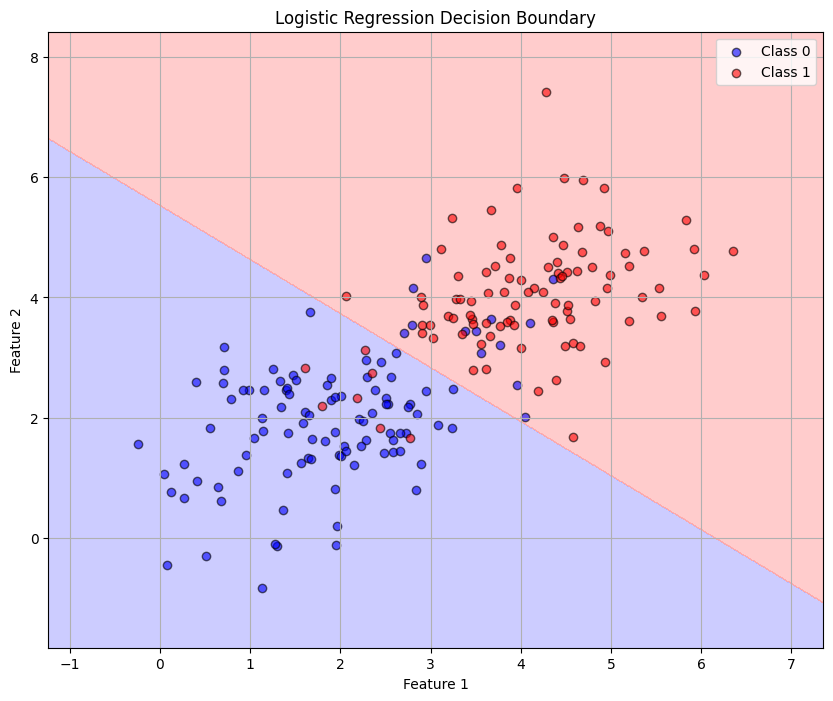

In [11]:
plot_decision_boundary(model, X_test, y_test, title='Logistic Regression Decision Boundary')